In [1]:
import os
import gc
import re
import cv2
import sys
import glob
from glob import glob
import tensorflow as tf
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import plotly.graph_objects as go

from tqdm  import tqdm
from keras import backend
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from keras.engine        import Layer, InputSpec
from keras.applications  import MobileNetV2
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Data Preparation

We will use the codes from previous notebook to extract all the data, images, dataframes and also the functions for modelling and also plotting

In [2]:
# Compose filenames
filelist_mt = glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/*.png')
filelist_shenzen     = glob('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
filelist             = filelist_mt + filelist_shenzen

In [3]:
j = 0
for i in filelist:
    print(i)
    if j == 5:
        break
    j+=1

../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0020_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0030_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0013_0.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0354_1.png
../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0044_0.png


In [4]:
def extract_label(file_list):
    '''
    Label Extraction Function
    Reads a filename and extracts label from it
    '''
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
#         print(current_label)
        labels.append(current_label[0])
    return(labels)

In [5]:
label = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 163369.36it/s]


In [6]:
len(label)

800

In [7]:
df = pd.DataFrame(filelist, columns = ['Path'])
df['Label'] = label

y = df['Label']
X = df.drop(['Label'], axis = 1)
X.shape, y.shape

((800, 1), (800,))

## Data Splitting

As what we have done before, we will split the data into 80:20 for training and testing, and 80:20 for training and validation

In [8]:
#80% Training 20% Testing
df_train, X_test, label_train, y_test = train_test_split(X,
                                                         y,
                                                         stratify = y,
                                                         random_state = 19,
                                                         test_size = 0.2)

In [9]:
# 80% Training 20% Validation
X_train, X_valid, y_train, y_valid = train_test_split(df_train,
                                                     label_train,
                                                     stratify = label_train,
                                                     random_state = 19,
                                                     test_size = 0.2)

In [10]:

print('Train size')
print(X_train.shape, y_train.shape)
print('Validation Size')
print(X_valid.shape, y_valid.shape)
print('Testing Size')
print(X_test.shape, y_test.shape)

Train size
(512, 1) (512,)
Validation Size
(128, 1) (128,)
Testing Size
(160, 1) (160,)


We will convert it into dataframe, to ease the process using the ImageDataGenerator by Keras

In [11]:

# Train
train_df = X_train.copy()
train_df['Label'] = y_train


#Valid
valid_df = X_valid.copy()
valid_df['Label'] = y_valid


#Test
test_df = X_test.copy()
test_df['Label'] = y_test

In [12]:
train_df.head()

,Path,Label
761,../input/pulmonary-chest-xray-abnormalities/Ch...,1
577,../input/pulmonary-chest-xray-abnormalities/Ch...,1
484,../input/pulmonary-chest-xray-abnormalities/Ch...,0
299,../input/pulmonary-chest-xray-abnormalities/Ch...,0
99,../input/pulmonary-chest-xray-abnormalities/Mo...,1


In [13]:
print("Train Value Counts")
print(train_df['Label'].value_counts())
print("Validation DF Value Counts")
print(valid_df['Label'].value_counts())
print("Test DF Value Counts")
print(test_df['Label'].value_counts())

Train Value Counts
0    260
1    252
Name: Label, dtype: int64
Validation DF Value Counts
0    65
1    63
Name: Label, dtype: int64
Test DF Value Counts
0    81
1    79
Name: Label, dtype: int64


In [14]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    image_dataframe = image_dataframe.reset_index(drop=True)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
#     print(image_dataframe)
    i = 1
    for j in range(rows):
        for k in range(columns):
            img = plt.imread(image_dataframe.loc[i-1,'Path'])
            img = cv2.resize(img, resize)
            if preprocessing:
                img = preprocessing(img)
            ax[j][k].set_title("Xray "+str(i))
            a = image_dataframe.loc[i-1, 'Label']
            if int(a) == 0:
                ax[j][k].set_xlabel('Normal')
            else:
                ax[j][k].set_xlabel('Tuberculosis')  
                
            ax[j][k].imshow(img, alpha=1, cmap='gray')
            i+=1
            
        if(i == (rows*columns)):
            break
    plt.show()

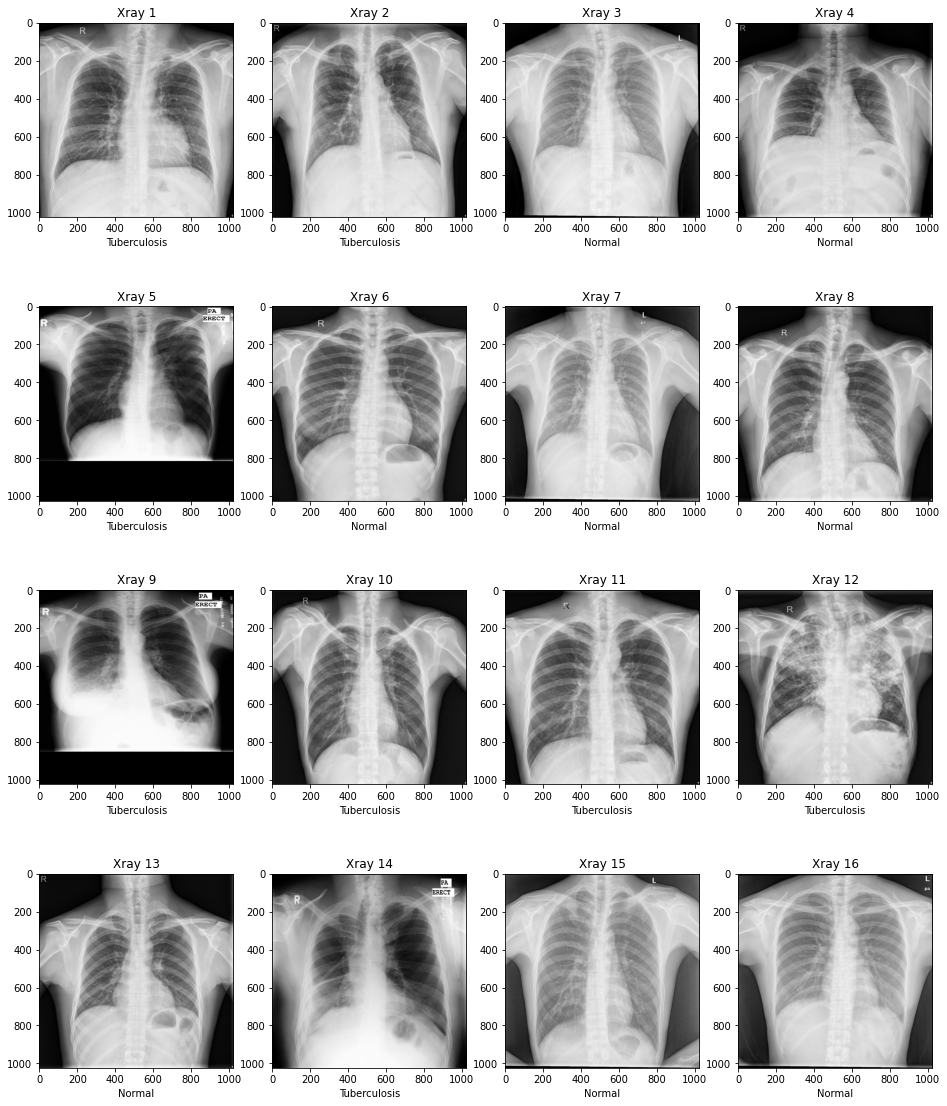

In [15]:
#Plotting Train images
plot_multiple_images(train_df)

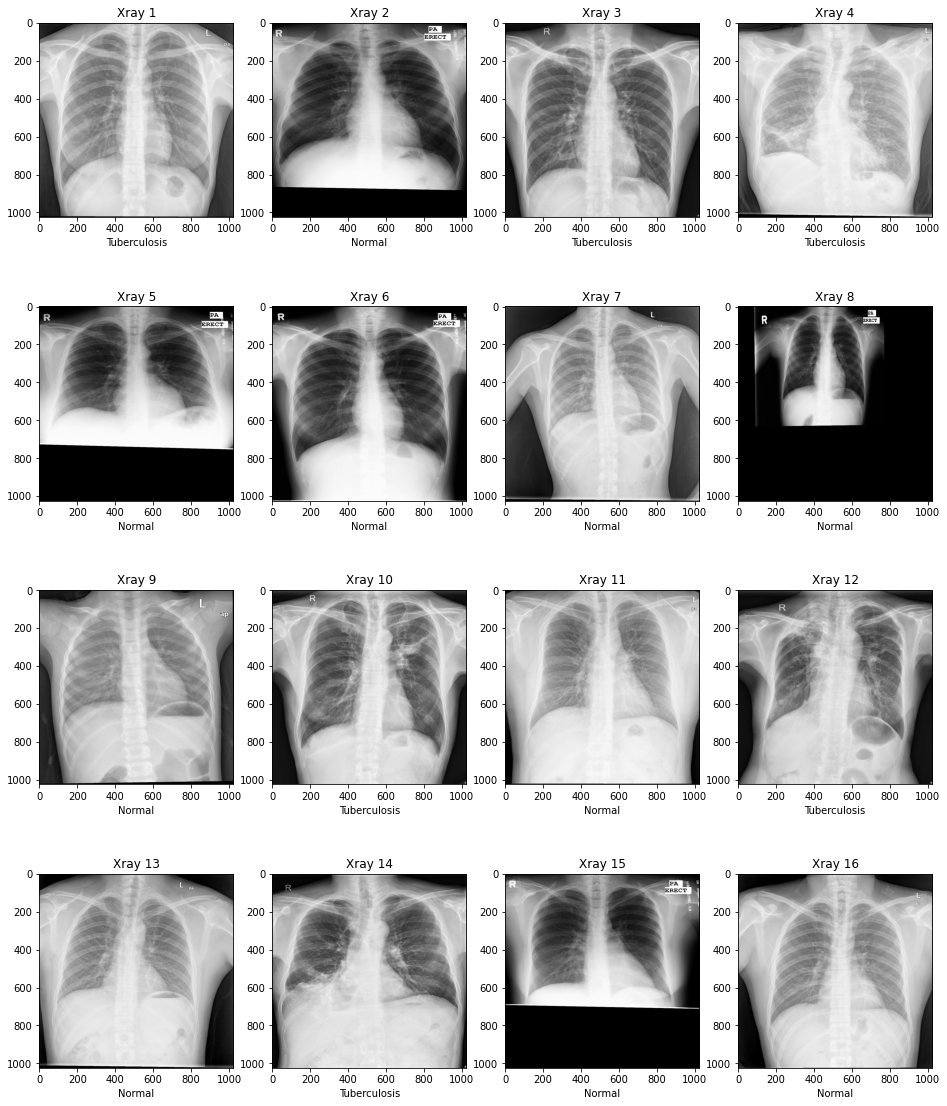

In [16]:
#Plotting Test Images
plot_multiple_images(valid_df)

## Setting up Train, Valid, Test Data from ImageDataGenerator

We'll cutdown the Image Input size to 224,224 to reduce time computation, and batch-size = 32 

In [17]:
BATCH = 32
IMAGE_INPUT = (224, 224)

In [18]:
def cal_steps(num_images, batch_size):
   # calculates steps for generator
   steps = num_images // batch_size

   # adds 1 to the generator steps if the steps multiplied by
   # the batch size is less than the total training samples
   return steps + 1 if (steps * batch_size) < num_images else steps

In [19]:
#Creating Training Data Generator
tf.random.set_seed(19)
train_generator = ImageDataGenerator(rescale = 1./255,)

# Create Validation data generator
test_generator  = ImageDataGenerator(rescale = 1./255,)

Still the same from out previous notebook, we will give some augmentation to the training data. This is done to prevent overfitting, and give challenges to our model to overcome

In [20]:
#Training Data
train_aug_generator = ImageDataGenerator(rescale = 1./255,
                                     zoom_range      = 0.05,
                                     shear_range     = 0,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     )


In [21]:
train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)

train_aug = train_aug_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
#Validation Data
valid = train_generator.flow_from_dataframe(dataframe = valid_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = True,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
valid2 = train_generator.flow_from_dataframe(dataframe = valid_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = False,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT,
                                    seed=19)
#Testing Data
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'Path',
                                    y_col       = 'Label',
                                    shuffle     = False,
                                    batch_size  = BATCH,
                                    target_size = IMAGE_INPUT)

Found 512 validated image filenames belonging to 2 classes.
Found 512 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.


In [22]:

def plot_training_hist(keras_model):
    '''
    Plot training History
    Creates two plots of model training logs
    '''
    hist = keras_model.history
    style.use('fivethirtyeight')
    
    # Loss Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Loss Plot')
    plt.plot(hist['loss'], '#07e9ed')
    plt.plot(hist['val_loss'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0,1.2 * max(max(hist['loss'], hist['val_loss']))])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
    # Accuracy Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Accuracy Plot')
    plt.plot(hist['accuracy'], '#07e9ed')
    plt.plot(hist['val_accuracy'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    
    #ROC Plot
    fig = plt.figure(figsize=(8,3))
    plt.title('Recall Plot')
    plt.plot(hist['recall'], '#07e9ed')
    plt.plot(hist['val_recall'], '#0791ed')
    plt.xlabel('Epochs')
    plt.ylabel('Recall Score')    
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    # Show Plot, reset style
    plt.show()
    style.use('default')

# Modelling

## ResNet50 V2
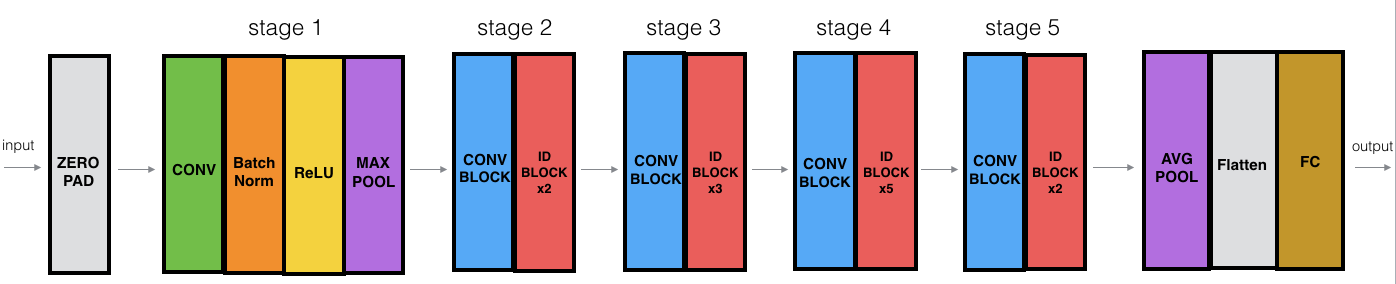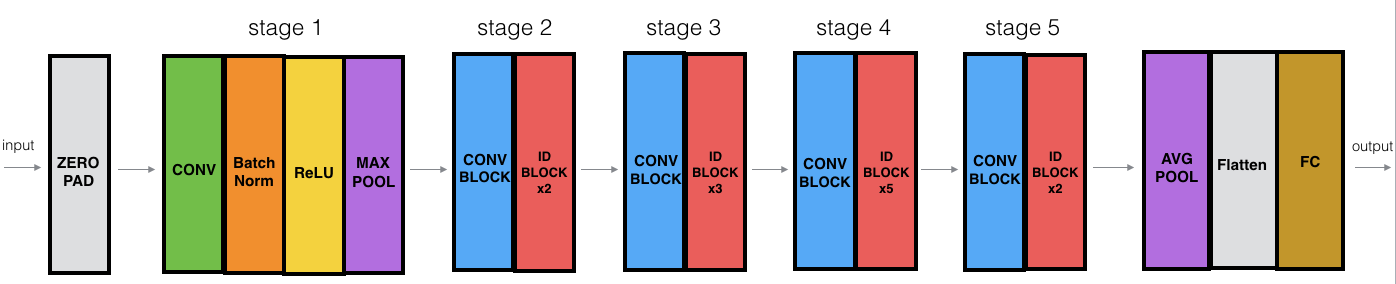



ResNet, short for a Residual Networks are usually used for many Computer Vision Tasks. It is able to perform greatly on unseen data, which also won the ImageNet Challenge in 2015. After going through many comparison between ResNet50, EfficientNetB0, EfficientNetb1, and DenseNet121, This pretrained model shows a stability amongst all model. Hence, this model is chosen for further modelling, tuning and evaluation

## Setting up Callbacks

In [23]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

In [24]:
#Defining Metrics
metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.Recall()]

## Experiment 1

For the first experiment with the ResNet50 V2, we tried adding batchnormalization and Dropout layers

In [25]:
# Making Resnet Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap

resnet_model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation = 'sigmoid'),
])


resnet_model.compile(loss='binary_crossentropy',
                    metrics = [metrics],
                    optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [26]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,575,041
Trainable params: 6,145
Non-trainable params: 23,568,896
_________________________________________________________________


In [27]:
resnet_history = resnet_model.fit(train_aug,
                                 validation_data = valid,
                                 steps_per_epoch =len(train_aug),
                                 validation_steps =  len(valid),
                                 epochs = 30,
                                 callbacks = [callbacks])

Epoch 1/30
16/16 [==============================] - 133s 8s/step - loss: 0.7425 - accuracy: 0.5750 - auc: 0.6272 - recall: 0.5891 - val_loss: 0.6582 - val_accuracy: 0.5391 - val_auc: 0.6437 - val_recall: 0.3810
val / train : 0.93
Epoch 2/30
16/16 [==============================] - 77s 5s/step - loss: 0.6271 - accuracy: 0.6791 - auc: 0.7265 - recall: 0.6487 - val_loss: 0.6106 - val_accuracy: 0.6641 - val_auc: 0.7470 - val_recall: 0.4286
val / train : 0.95
Epoch 3/30
16/16 [==============================] - 77s 5s/step - loss: 0.5856 - accuracy: 0.6983 - auc: 0.7702 - recall: 0.6713 - val_loss: 0.5649 - val_accuracy: 0.7188 - val_auc: 0.8010 - val_recall: 0.5397
val / train : 0.96
Epoch 4/30
16/16 [==============================] - 75s 5s/step - loss: 0.5832 - accuracy: 0.7041 - auc: 0.7804 - recall: 0.6915 - val_loss: 0.5390 - val_accuracy: 0.6953 - val_auc: 0.8228 - val_recall: 0.5714
val / train : 0.97
Epoch 5/30
16/16 [==============================] - 77s 5s/step - loss: 0.4994 - ac

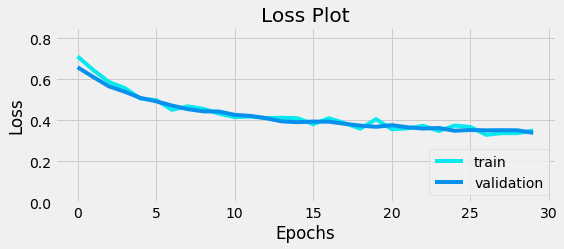

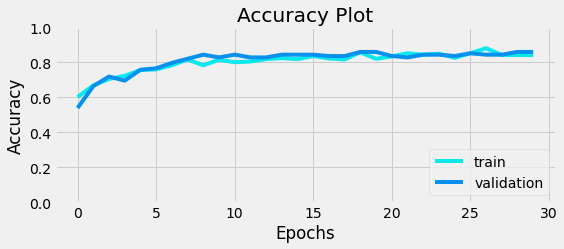

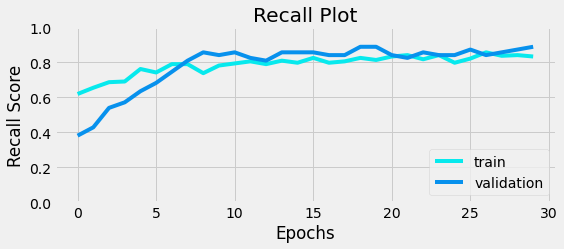

In [28]:
plot_training_hist(resnet_history)

The model seems to have improved, and we will move on to the next experiment

## Experiment 2

The previous one is really a good model, compared without any batchnormalization and dropout. We will try to add more dense layers and change the activation function of the layers and see how it affects the performance of the model

In [29]:
# Making Resnet Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap

resnet_model2 = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dense(80, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(80, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

resnet_model2.compile(loss='binary_crossentropy',
                    metrics = [metrics],
                    optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [30]:
resnet_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 80)                163920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 80)                320       
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
batch_normalization_2 (Batch (None, 80)                3

In [31]:
feature_extractor_layer.output_shape

(None, 2048)

In [32]:
resnet_history2 = resnet_model2.fit(train_aug,
                                 validation_data = valid,
                                steps_per_epoch = len(train_aug),
                                 validation_steps =  len(valid),
                                 epochs = 30,
                                 callbacks = [callbacks])

Epoch 1/30
16/16 [==============================] - 80s 5s/step - loss: 0.8949 - accuracy: 0.5638 - auc: 0.7371 - recall: 0.7115 - val_loss: 0.5818 - val_accuracy: 0.7109 - val_auc: 0.8508 - val_recall: 0.4444
val / train : 0.76
Epoch 2/30
16/16 [==============================] - 76s 5s/step - loss: 0.5535 - accuracy: 0.7143 - auc: 0.8085 - recall: 0.7032 - val_loss: 0.5898 - val_accuracy: 0.7578 - val_auc: 0.8869 - val_recall: 0.5238
val / train : 1.08
Epoch 3/30
16/16 [==============================] - 72s 5s/step - loss: 0.5372 - accuracy: 0.7609 - auc: 0.8283 - recall: 0.7548 - val_loss: 0.6069 - val_accuracy: 0.7500 - val_auc: 0.8933 - val_recall: 0.5079
val / train : 1.20
Epoch 4/30
16/16 [==============================] - 72s 5s/step - loss: 0.4547 - accuracy: 0.7853 - auc: 0.8704 - recall: 0.7962 - val_loss: 0.5330 - val_accuracy: 0.7656 - val_auc: 0.9076 - val_recall: 0.5397
val / train : 1.25
Epoch 5/30
16/16 [==============================] - 72s 5s/step - loss: 0.4172 - acc

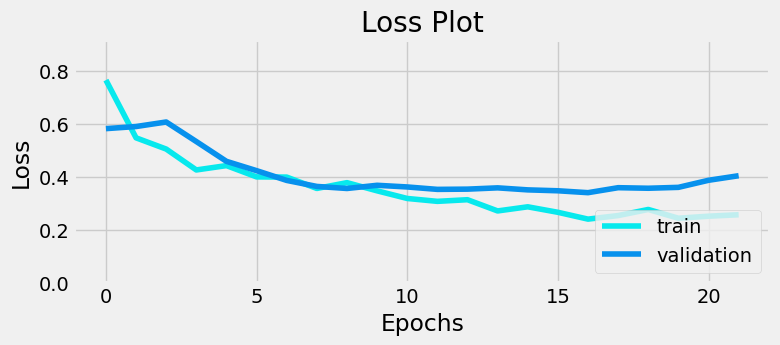

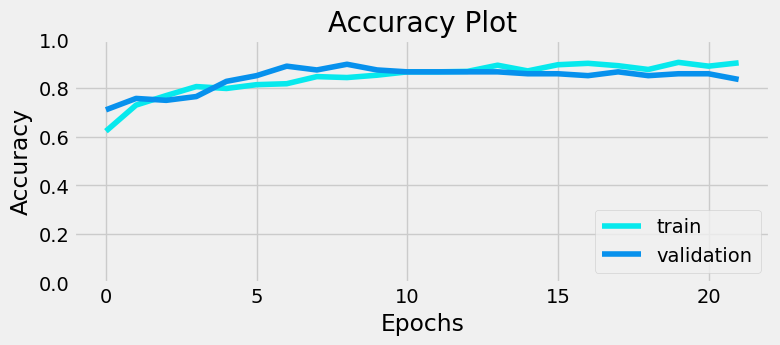

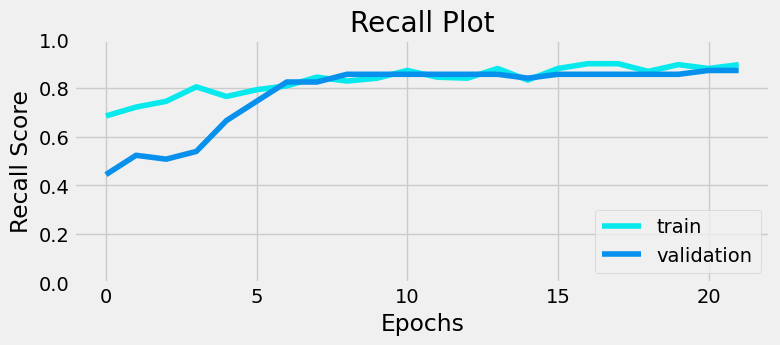

In [33]:
plot_training_hist(resnet_history2)

On the second experiment, the model looks to have improved by a lot! We will use this model architecture for further parameter tuning and evaluation

# HyperParameter Tuning with HyperBand

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
import keras_tuner as kt
import numpy as np

We will now create a function which return our model. The keras api used for hyperparameter requires a function which return a model for parameter searching

In [35]:
def model_builder(hp):
    model = keras.Sequential()
    resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
    feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap

    hp_units = hp.Int('units', min_value=80, max_value=160, step=40)
    hp_dropout = hp.Choice('dropoutRate', values=[0.2, 0.3, 0.4])
    hp_activation = hp.Choice('activation', values = ['elu', 'relu'])
    model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units = hp_units, activation = hp_activation, kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(hp_dropout),
    keras.layers.Dense(units = hp_units, activation = hp_activation, kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(hp_dropout),
    keras.layers.Dense(1, activation = 'sigmoid'),
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-3, 5e-4, 5e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=[metrics])

    return model

I will be using HyperBand as the tuning algorithm. Hyperband is a relatively new method for tuning iterative algorithms. It performs random sampling and attempts to gain an edge by using time spent optimizing in the best way. It's faster and better than Randomized tuning algorithm.

In [36]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='tuning_model',
                    seed = 19)

We will focus on val_accuracy, because on the previous hyperparameter tuning, making the objective into val_recall will make the model focus too much on the recall, causing it to be underfitting when it tried to predict unseen data

In [37]:
#Searching for best parameter
#Using only early_stopping callback(patience = 5)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_aug, validation_data = valid, epochs = 20, callbacks = [stop_early])

Trial 30 Complete [00h 24m 54s]
val_accuracy: 0.8671875

Best val_accuracy So Far: 0.890625
Total elapsed time: 04h 44m 40s


After the searching is finished, we can extract the model parameters and see the compositions

In [38]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'units': 120,
 'dropoutRate': 0.4,
 'activation': 'elu',
 'learning_rate': 0.0005,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '64a295c86b2f2faa4d0a5d64740f59a4'}

We got the best parameters! Now lets continue to final fitting for evaluation

In [39]:
# We can also use customized callback, where we customize them on our own
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs): 
    print("val / train : {:.2f}".format(logs['val_loss']/logs['loss']))
    
#Another Additional callbacks (Checkpoint, Early Stopping)
checkpoint_cb = keras.callbacks.ModelCheckpoint("tuned_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 
callbacks = [checkpoint_cb, early_stopping_cb, PrintValTrainRatioCallback()]

We will manually input the parameters gained from the tuner, and create a model for evaluation

In [40]:
# Making Resnet Model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
resnet50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
feature_extractor_layer = hub.KerasLayer(resnet50_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_INPUT+(3,)) # define the input image shap

resnet_model3 = keras.Sequential([
    feature_extractor_layer,
    keras.layers.BatchNormalization(),
    keras.layers.Dense(160, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(160, activation = 'elu', kernel_initializer = 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

resnet_model3.compile(loss='binary_crossentropy',
                    metrics = [metrics],
                    optimizer = keras.optimizers.Adam(learning_rate = 5e-4))

In [41]:
resnet_history3 = resnet_model3.fit(train_aug,
                 validation_data = valid,
                 steps_per_epoch = len(train),
                validation_steps = len(valid),
                  epochs = 20,
        callbacks = [callbacks])

Epoch 1/20
16/16 [==============================] - 83s 5s/step - loss: 0.8495 - accuracy: 0.5583 - auc: 0.7527 - recall: 0.6752 - val_loss: 0.9660 - val_accuracy: 0.5625 - val_auc: 0.8465 - val_recall: 0.1111
val / train : 1.24
Epoch 2/20
16/16 [==============================] - 77s 5s/step - loss: 0.5242 - accuracy: 0.7291 - auc: 0.8269 - recall: 0.7088 - val_loss: 0.6850 - val_accuracy: 0.6875 - val_auc: 0.9073 - val_recall: 0.3651
val / train : 1.30
Epoch 3/20
16/16 [==============================] - 77s 5s/step - loss: 0.4462 - accuracy: 0.7797 - auc: 0.8747 - recall: 0.8023 - val_loss: 0.4693 - val_accuracy: 0.7656 - val_auc: 0.9078 - val_recall: 0.5714
val / train : 1.02
Epoch 4/20
16/16 [==============================] - 73s 5s/step - loss: 0.4531 - accuracy: 0.7810 - auc: 0.8709 - recall: 0.7817 - val_loss: 0.4004 - val_accuracy: 0.8281 - val_auc: 0.9203 - val_recall: 0.6825
val / train : 0.89
Epoch 5/20
16/16 [==============================] - 77s 5s/step - loss: 0.3883 - acc

In [42]:
resnet_model3.save_weights('final_model.h5')

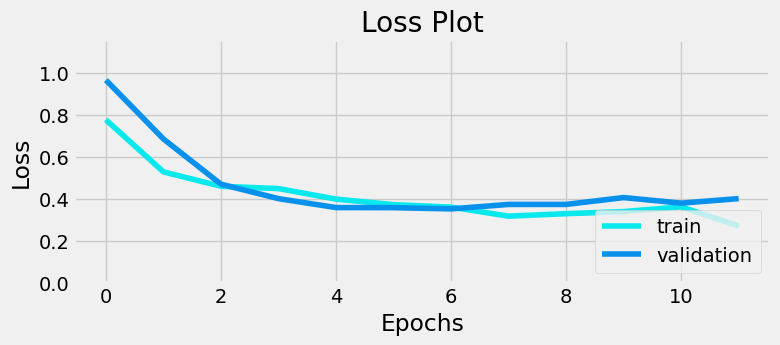

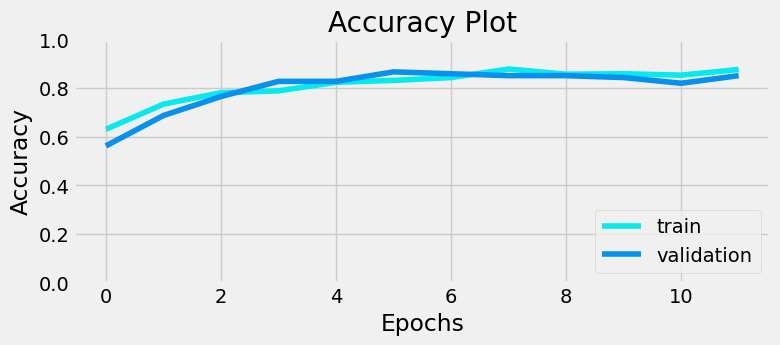

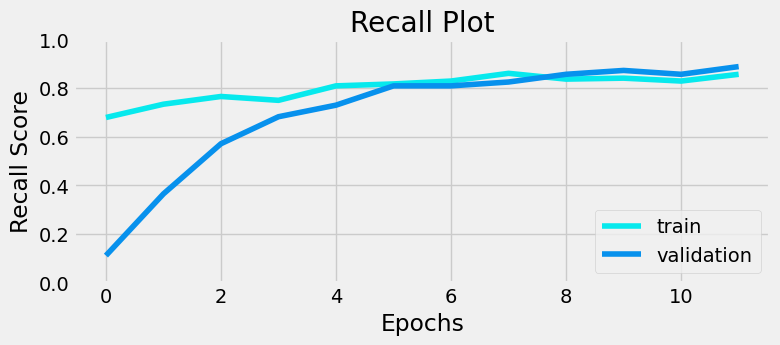

In [43]:
plot_training_hist(resnet_history3)

In [44]:
def plot_roc_curve(*datas):
  fig = go.Figure()
  for data in datas:
    name = data[0]
    y_true = data[1]
    pred = data[2]

    fpr, tpr, _ = roc_curve(y_true, pred)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name))
    
  fig.update_yaxes(title_text="TPR")
  fig.update_xaxes(title_text="FPR")
  fig.update_layout(title_text="ROC Curve")
  fig.show()

In [45]:
def predictValues(model, valid, y_real):
    pred = model.predict(valid)
    a =[]
    for i in pred:
        if i > 0.5:
            a.append(int(1))
        else:
            a.append(int(0))
    print("Accuracy score : ", accuracy_score(y_real, a))
    print("Recall score : ", recall_score(y_real, a, average = 'weighted'))
    return a

In [46]:
resnet_model3.evaluate(valid)

4/4 [==============================] - 15s 4s/step - loss: 0.3516 - accuracy: 0.8594 - auc: 0.9220 - recall: 0.8095


[0.35155045986175537, 0.859375, 0.9219779968261719, 0.8095238208770752]

In [47]:
y_true = valid_df['Label']
y_true = y_true.astype('int')
pred = predictValues(resnet_model3, valid2, y_true)

Accuracy score :  0.859375
Recall score :  0.859375


In [48]:
print(classification_report(y_true, pred, labels=[0,1], zero_division=1))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        65
           1       0.89      0.81      0.85        63

    accuracy                           0.86       128
   macro avg       0.86      0.86      0.86       128
weighted avg       0.86      0.86      0.86       128



In [49]:
plot_roc_curve(['resnet_model3', y_true, pred])

We will be using the threshold of 0.33 instead of 0.5, to increase our recall for the unseen dataset

# Evaluation on Unseen Data

In [50]:
# Get label
y_real = test_df['Label']

In [51]:
#Change the datatype to int
y_real = y_real.astype('int')

In [52]:
loss, acc, auc, recall = resnet_model3.evaluate(test)

5/5 [==============================] - 28s 6s/step - loss: 0.4403 - accuracy: 0.8188 - auc: 0.8798 - recall: 0.7215


In [53]:
def predictUnseenValues(model, test):
    pred = model.predict(test)
    a =[]
    for i in pred:
        if i > 0.33:
            a.append(int(1))
        else:
            a.append(int(0))
    print("Accuracy score : ", accuracy_score(y_real, a))
    print("Recall score : ", recall_score(y_real, a, average = 'weighted'))
    return a

In [54]:
final_pred= predictUnseenValues(resnet_model3,test)

Accuracy score :  0.80625
Recall score :  0.80625


In [55]:
print(classification_report(y_real, final_pred, labels=[0,1], zero_division=1))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        81
           1       0.79      0.82      0.81        79

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



We get a recall of 0.86! It is a really great improvement

In [56]:
a = confusion_matrix(y_real, final_pred)
a

array([[64, 17],
       [14, 65]])

In [57]:
plot_roc_curve(['resnet_model3', y_real, final_pred])

- True Positive : 64
- False Negative : 17
- False Positive : 11
- True Negative : 68


We could get a 86% recall rate, which can save the doctor's time by a lot!